In [1]:
%matplotlib inline

In [2]:
# numpy pandas matplotlib seaborn scikit-learn xgboost lightgbm eli5 imblearn hyperop

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sklearn 
sklearn.__version__

'0.22.1'

In [3]:
# !pip install --upgrade scikit-learn

In [4]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = metrics.precision_score(y_test, y_pred),
    recall = metrics.recall_score(y_test, y_pred),

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision_vec, recall_vec, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall_vec, precision_vec)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall_vec, precision_vec, 
                       label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].plot(recall, precision, 'ro',
                       markersize=8, label='Decision Point')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')          
            ax[2].legend()

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats


## Investigating advanced classifiers

### Getting Ready

Prepare the Pipeline:

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

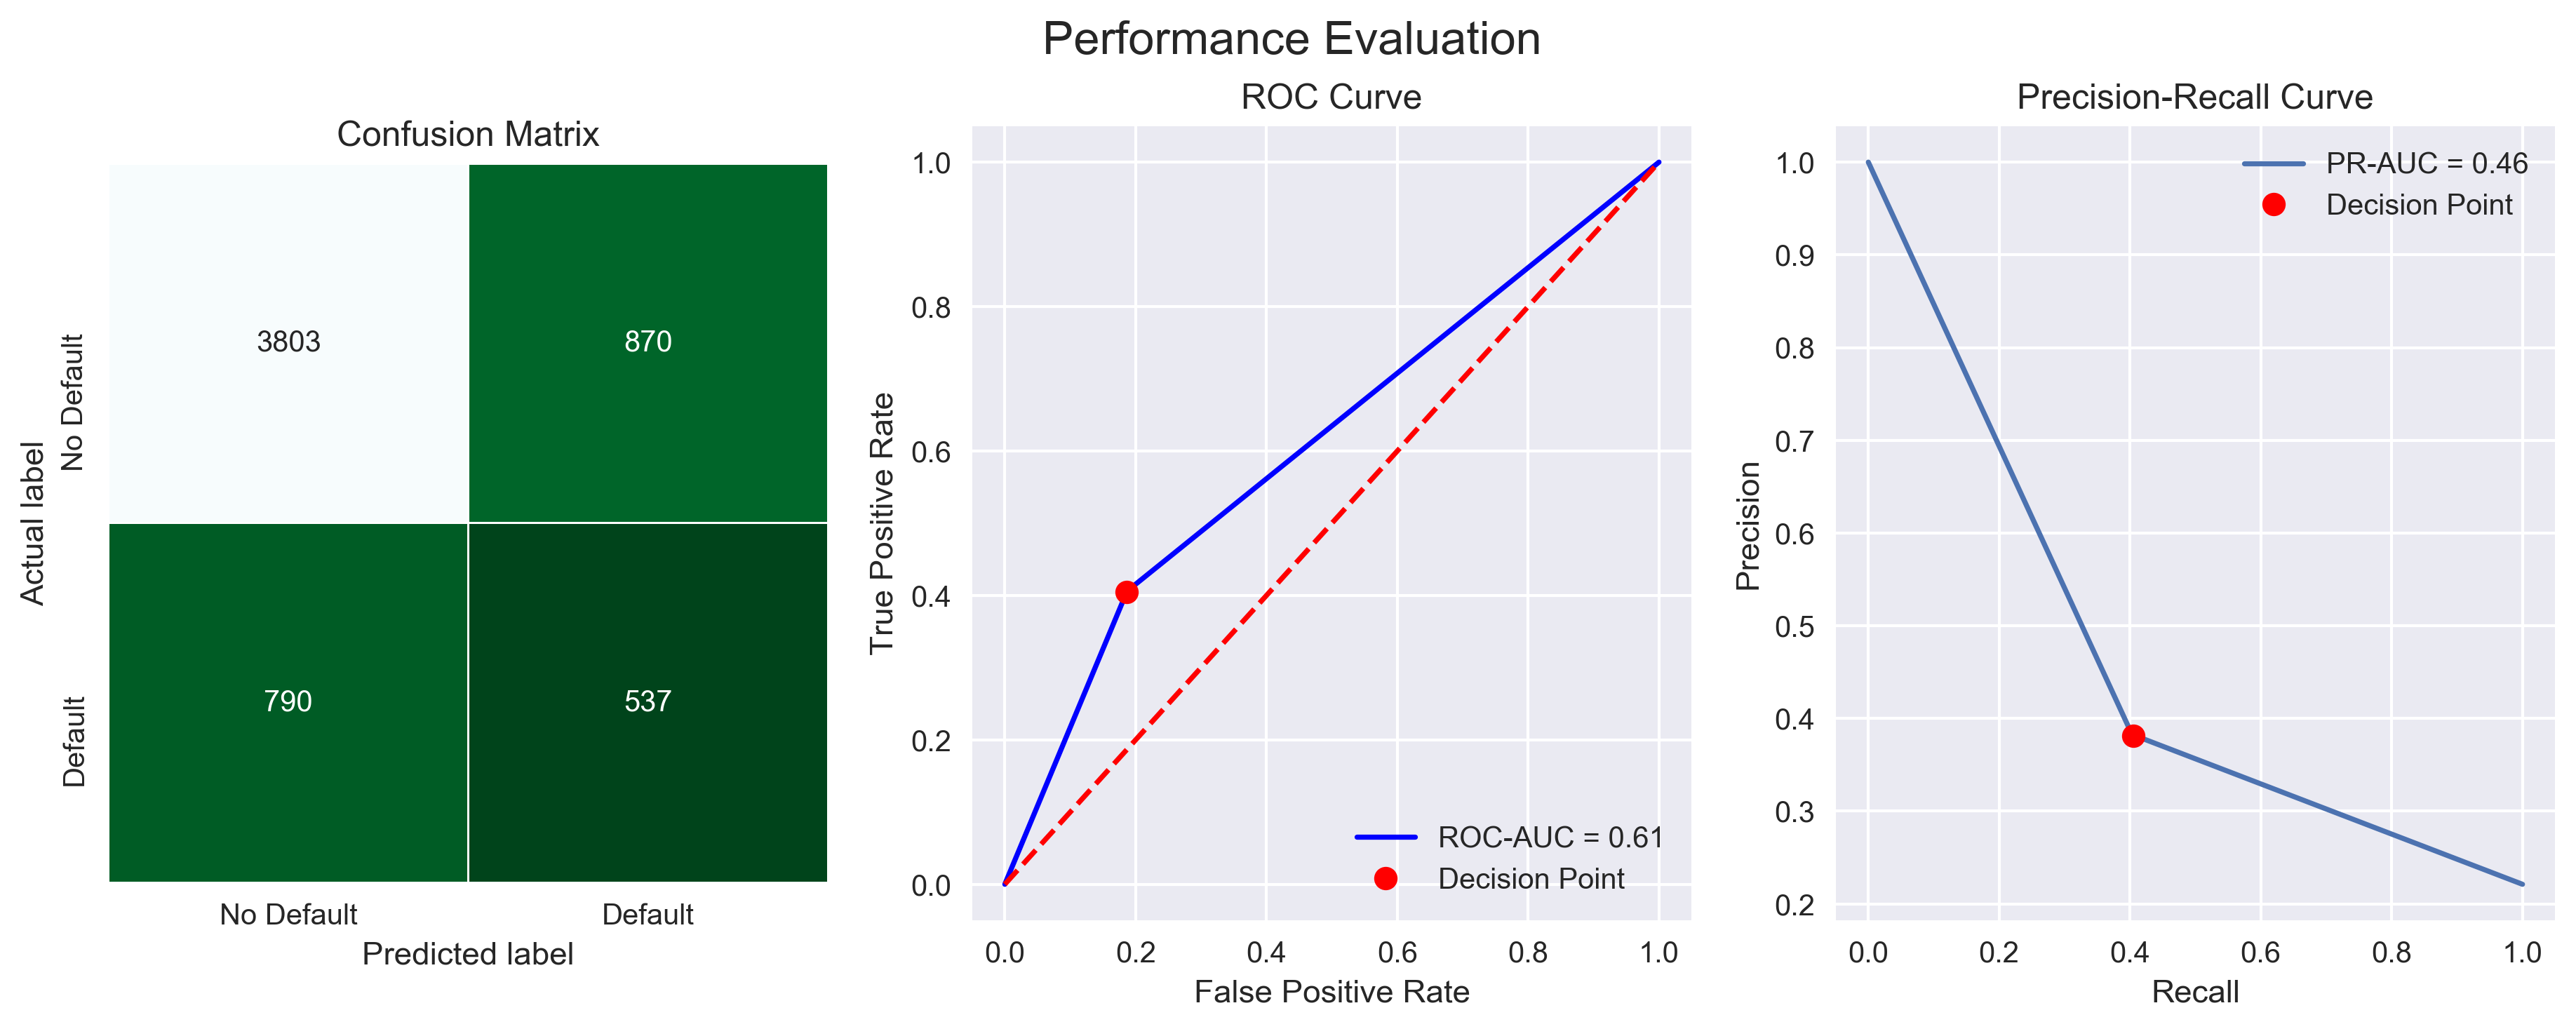

In [6]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

num_features = X_train.select_dtypes(include='number').columns.to_list()
cat_features = X_train.select_dtypes(include='object').columns.to_list()

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

cat_list = [list(X_train[column].dropna().unique()) for column in cat_features]

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown='error', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', DecisionTreeClassifier(random_state=42))])

tree_pipeline.fit(X_train, y_train)

LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True, 
                                          show_pr_curve=True)

In [7]:
tree_perf

{'accuracy': 0.7233333333333334,
 'precision': 0.3816631130063966,
 'recall': 0.4046721929163527,
 'specificity': 0.8138240958698909,
 'f1_score': 0.3928310168251646,
 'cohens_kappa': 0.21388003714653614,
 'roc_auc': 0.6095279347712678,
 'pr_auc': 0.4589251149708047}

In [11]:
# investigate the depth of the tree
tree_classifier = tree_pipeline.named_steps['classifier']
tree_classifier.tree_.max_depth

37

### How to do it...

1. Import the libraries:

In [12]:
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

2. Create a Random Forest Pipeline:

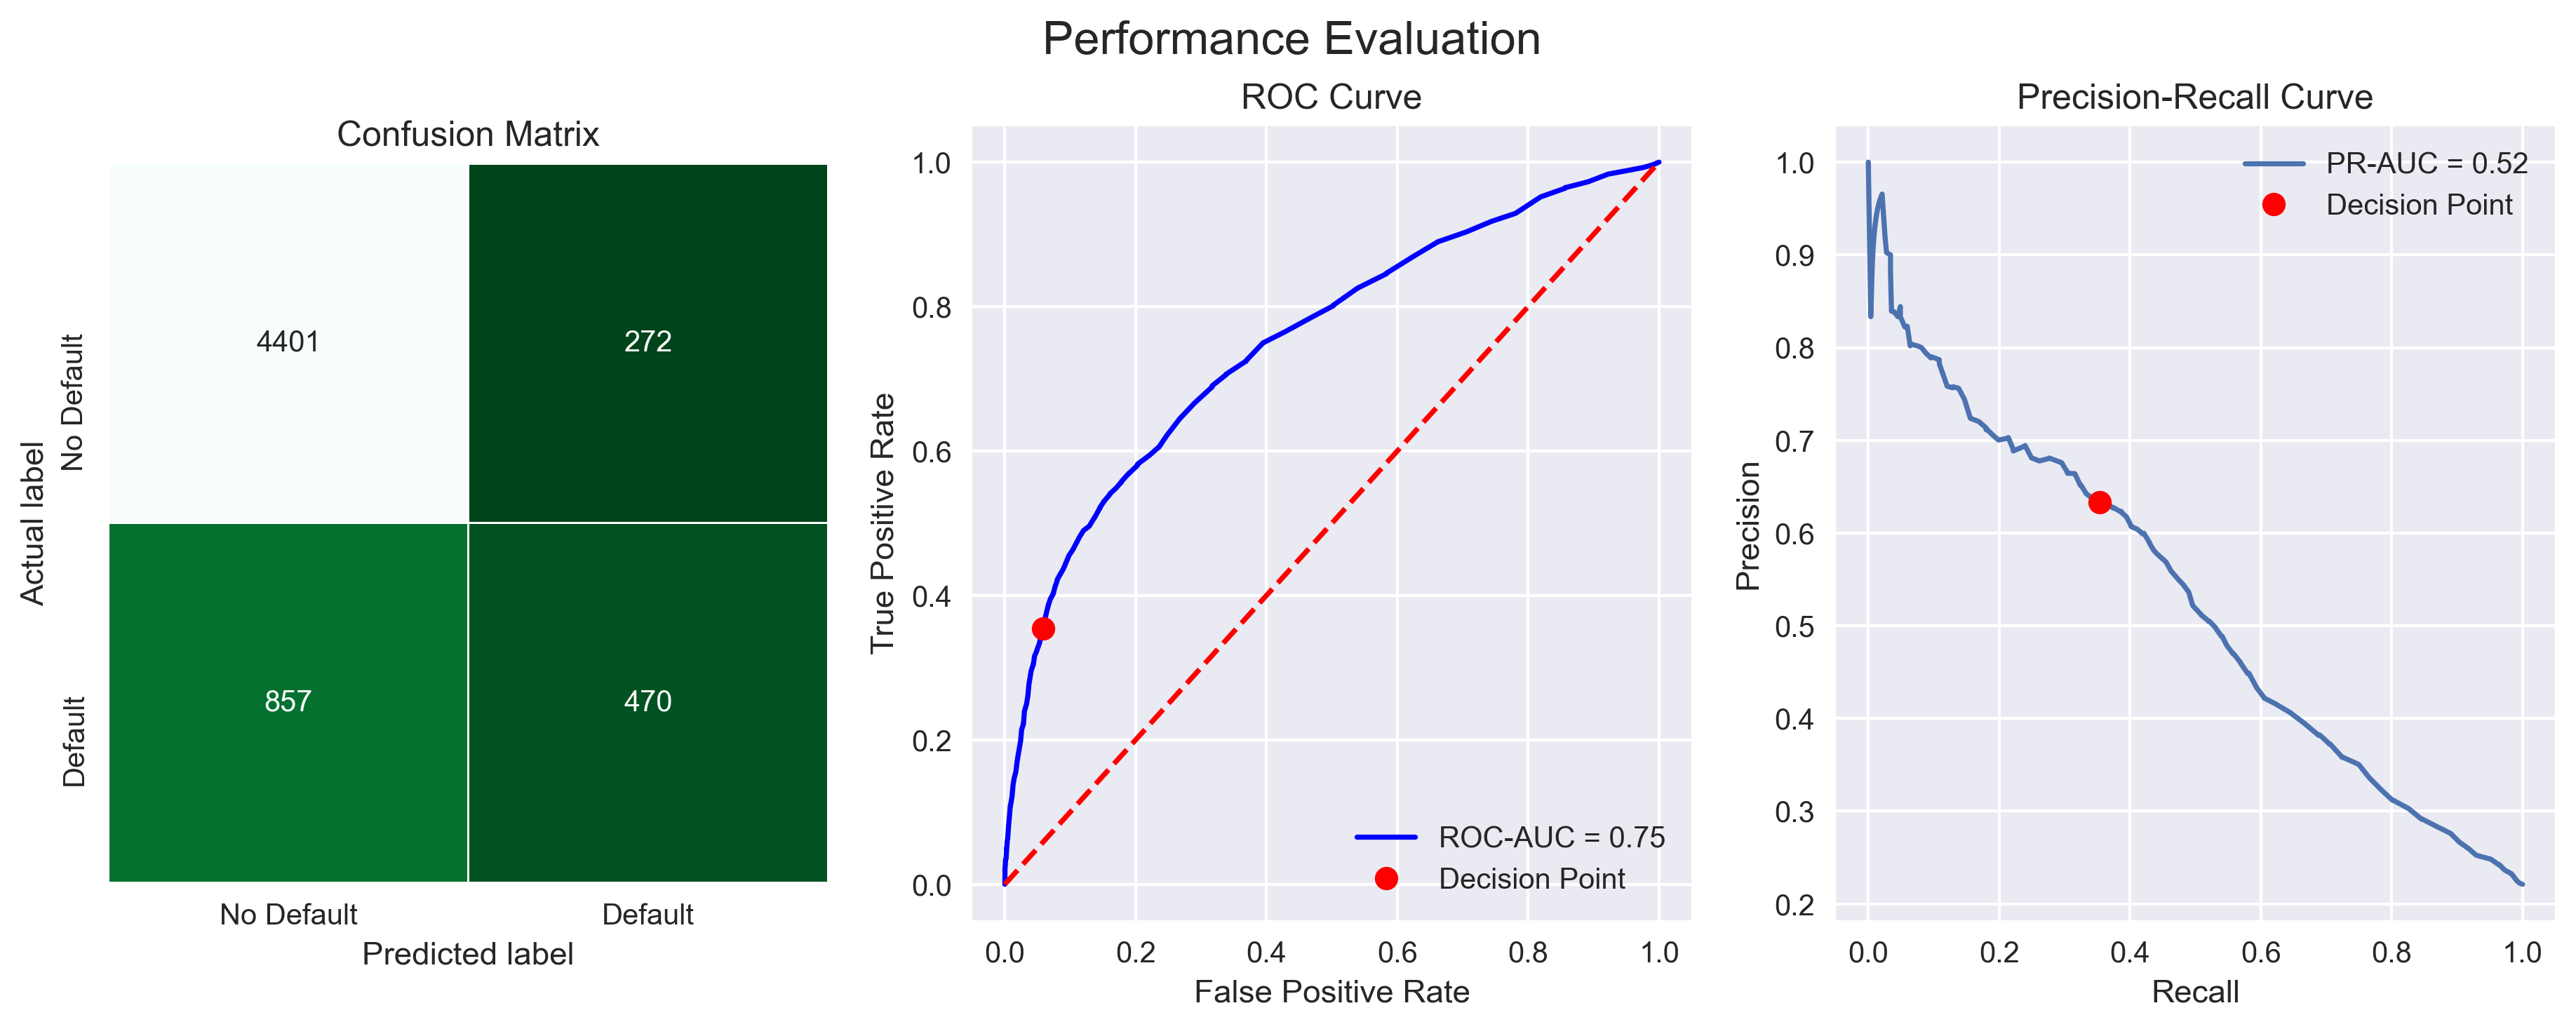

In [13]:
rf = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf)
                             ])

rf_pipeline.fit(X_train, y_train)
rf_perf = performance_evaluation_report(rf_pipeline, X_test, 
                                        y_test, labels=LABELS, 
                                        show_plot=True,
                                        show_pr_curve=True)

plt.show()

3. Create a Gradient Boosting Trees Pipeline:

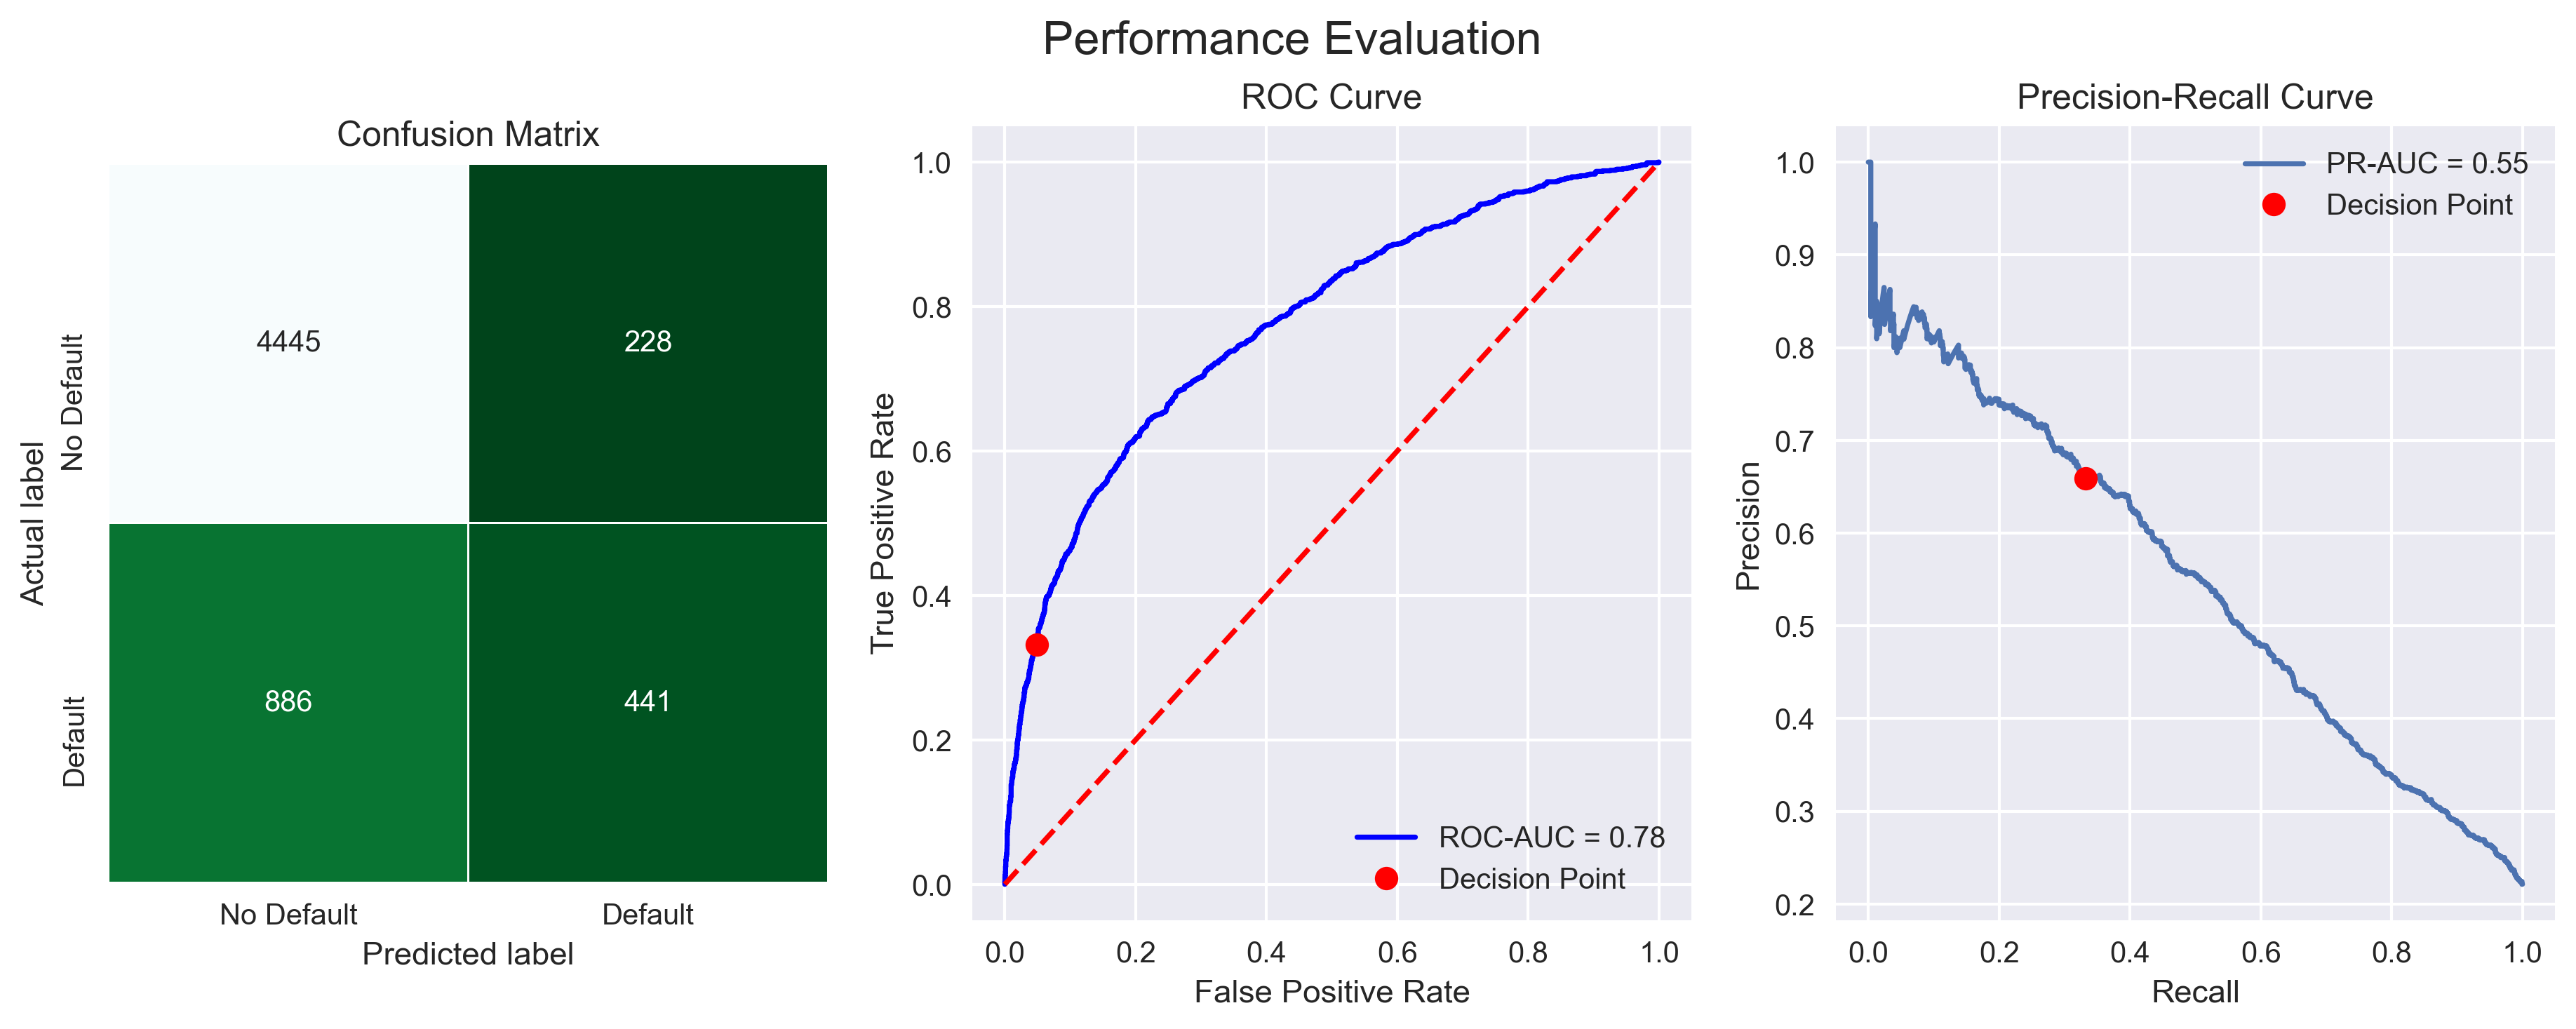

In [14]:
gbt =  GradientBoostingClassifier(random_state=42)
gbt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', gbt)
                              ])

gbt_pipeline.fit(X_train, y_train)
gbt_perf = performance_evaluation_report(gbt_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True,
                                         show_pr_curve=True)

plt.show()

4. Create a xgBoost Pipeline:

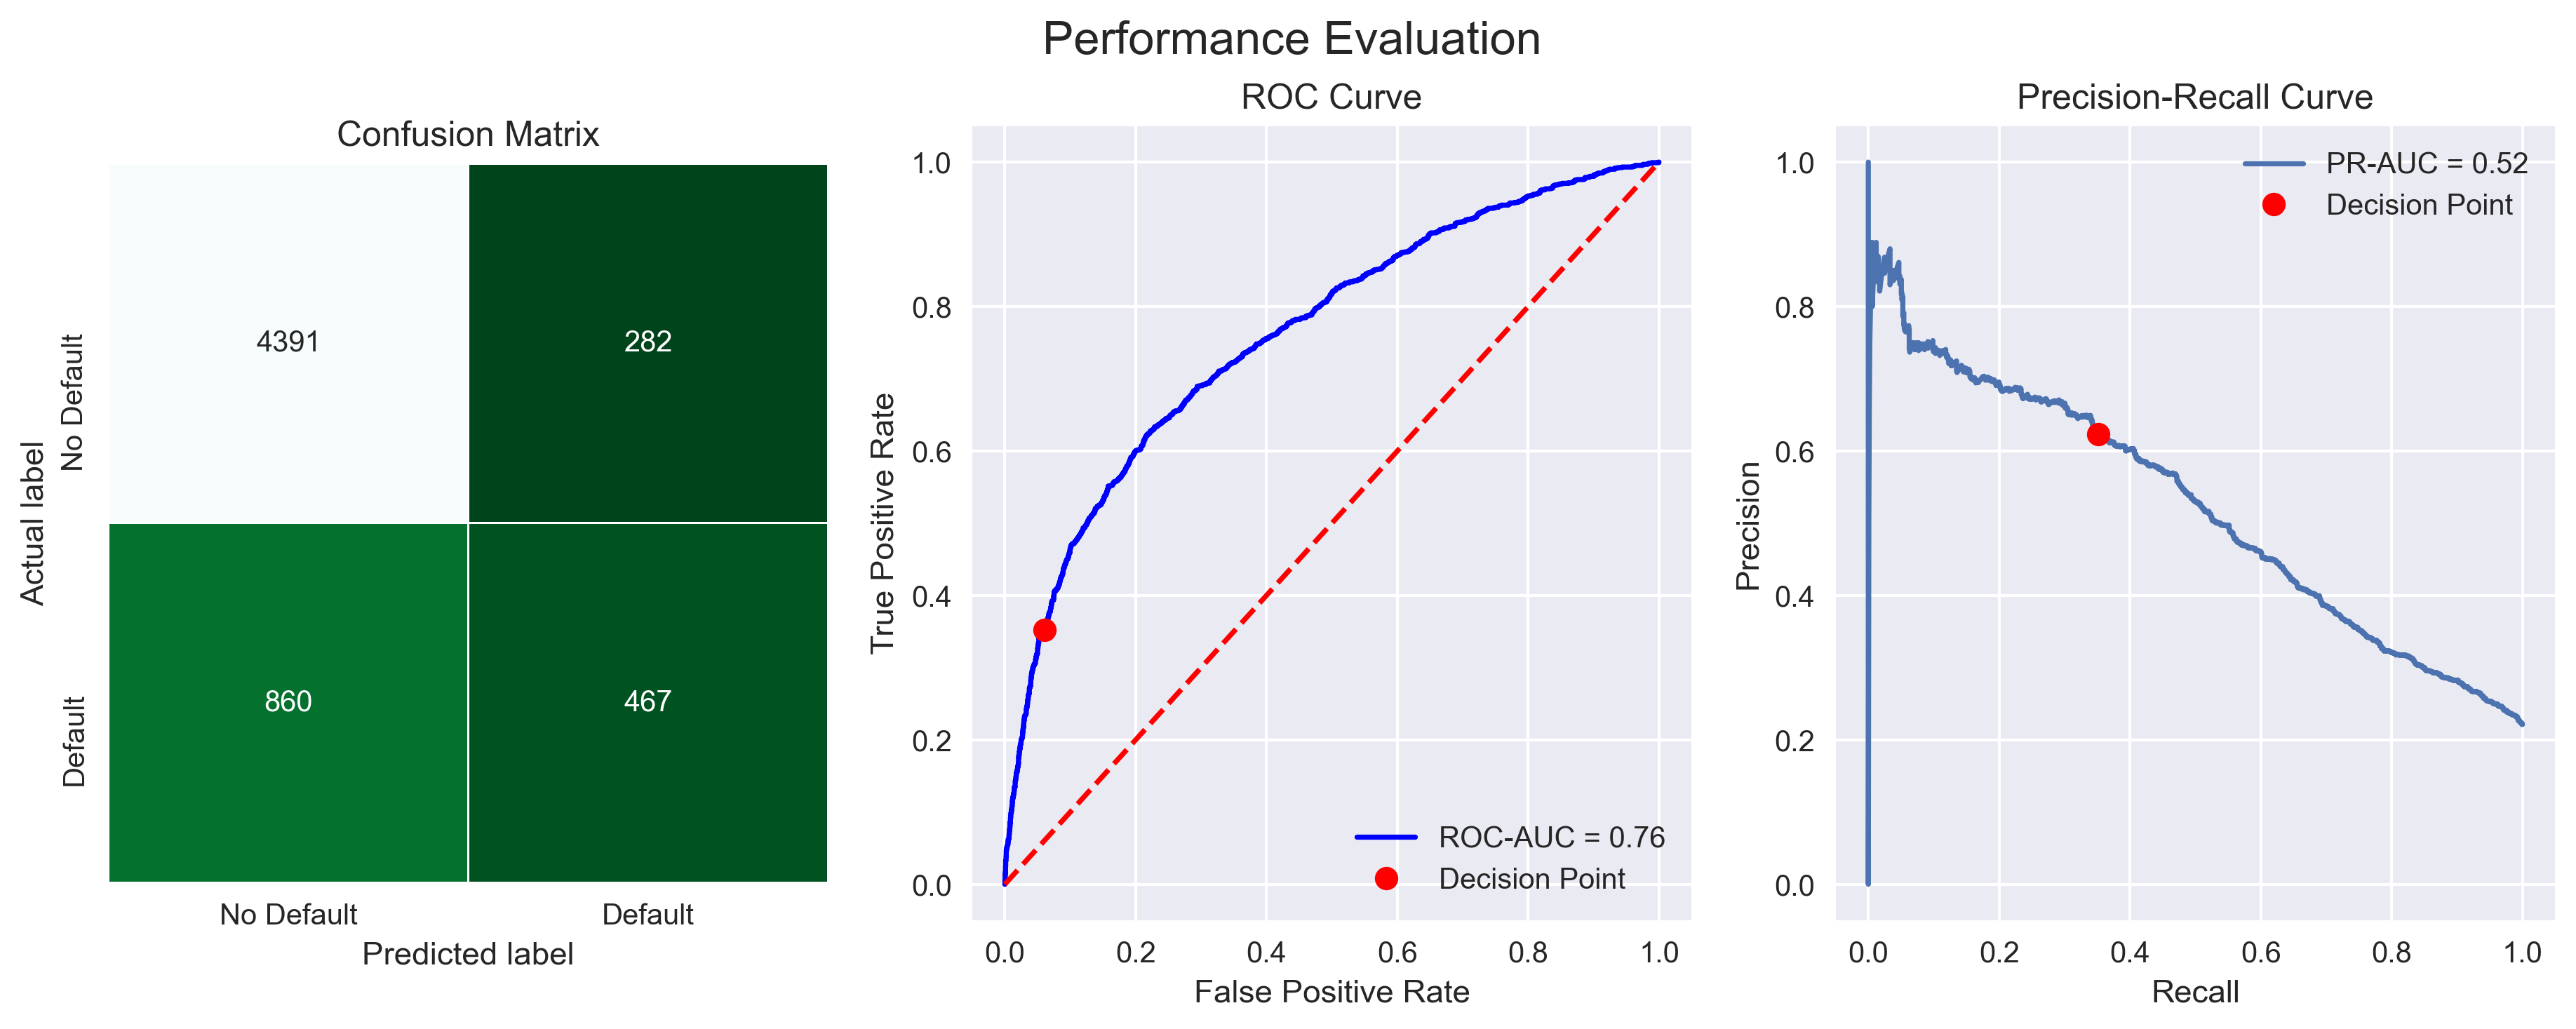

In [15]:
xgb = XGBClassifier(random_state=42)
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb)
                              ])

xgb_pipeline.fit(X_train, y_train)
xgb_perf = performance_evaluation_report(xgb_pipeline, X_test, 
                                         y_test, labels=LABELS, 
                                         show_plot=True,
                                         show_pr_curve=True)

plt.show()

5. Create a LightGBM classifier Pipeline:

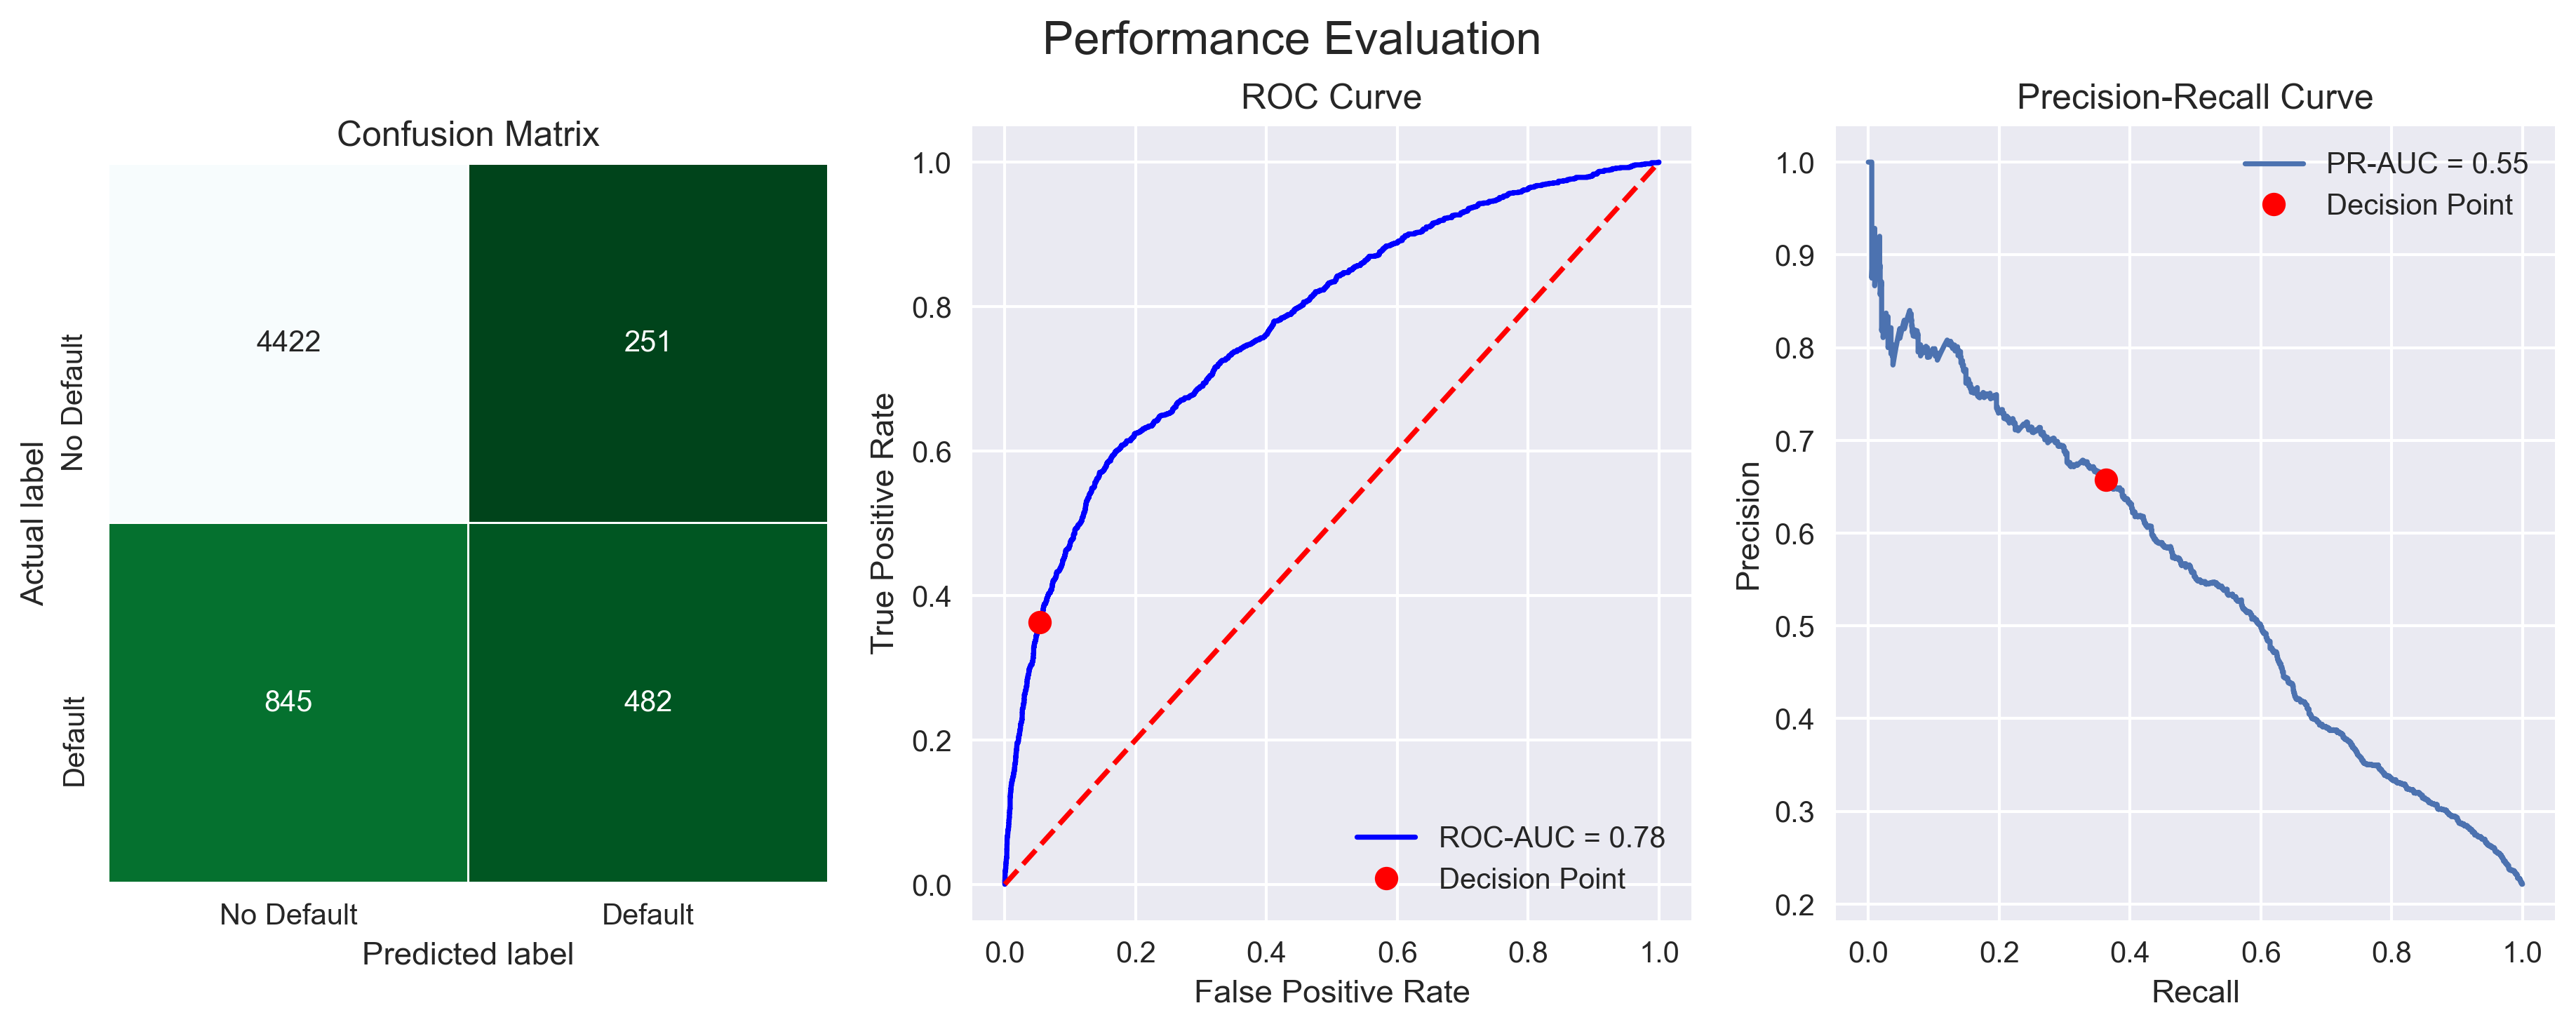

In [16]:
lgbm = LGBMClassifier(random_state=42)
lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', lgbm)
                               ])

lgbm_pipeline.fit(X_train, y_train)
lgbm_perf = performance_evaluation_report(lgbm_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True,
                                          show_pr_curve=True)

plt.show()